# Full-waveform inversion using Forge

***

### Contents

1. Model definition
2. Acquisition setup
3. Forward modelling
4. Optimization

***

In [1]:
from forge import *

## 1. Model definition

In [2]:
# choose the frequency of the source wavelet and the acoustic velocities of the model
frequency = 2e5
min_vel = 1480
med_vel = 1520
max_vel = 1620

### Numerical dispersion

Set the spatial increment, `dx`, to be small enough to sufficiently mitigate numerical dispersion by ensuring there are a 6 grid-points per wavelength.

In [3]:
min_wavelength = min_vel/frequency
dx = min_wavelength/6
print(f'spatial increment dx: {dx:.3g}')

spatial increment dx: 0.00123


### Numerical stability

Set the temporal increment, `dt`, to be small enough to meet the CFL condition for numerical stability. 

In [4]:
courant_num = 0.61 
dt = (courant_num*dx)/max_vel
print(f'temporal increment dt: {dt:.3g}')

temporal increment dt: 4.64e-07


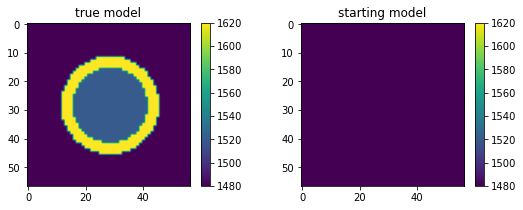

In [5]:
# define the true model, m, and the inversion starting model m0
m, m0 = demo_model(dx, min_vel, med_vel, max_vel, plot=True)

## 2. Acquisition setup

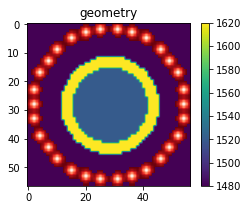

In [6]:
# define the receiver and source geometry
r_pos = demo_geometry(m, n_elements=30, plot=True)
s_pos = r_pos.copy()

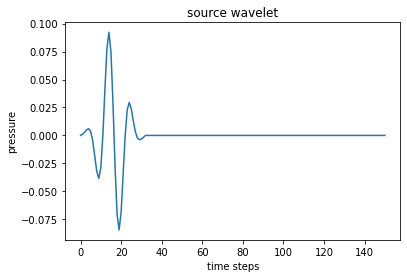

In [7]:
time = 0.00007 # maximum time in seconds
amplitude = 1e-1 # source amplitude
num_tsteps = int(np.ceil(time/dt)) # number of time-steps
num_cycles = 3 # use a 3 cycle tone-burst

# define the source wavelet 
source = tone_burst(dt, frequency, num_cycles, num_tsteps, amplitude, plot=True)

## 3. Forward modelling

In [8]:
# instantiate a Forge WaveformInversion_2d class
true_model = WaveformInversion_2d(model = m, # true model
                                  dx = dx, # spatial increment
                                  dt = dt, # temporal increment
                                  r_pos = r_pos) # receiver positions

device = cpu


In [9]:
# configure the source positions and source wavelet
true_model.configure(s_pos, source)

In [10]:
# forward modelling
true_model.forward()

                Forward modelling | 151/151 | ✓


In [11]:
# extract the true modelled data
d = true_model.d

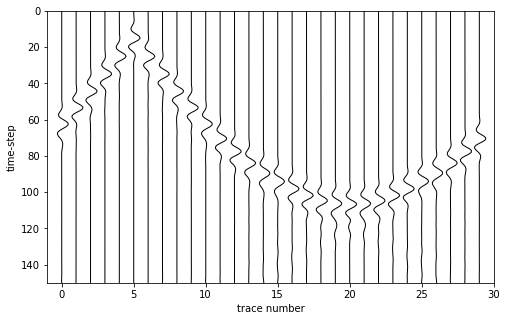

In [12]:
# visualize traces of true modelled data
trace_plot(trace_normalize(d), 5, fill=False)

In [13]:
# animate partial derivative of forward wavefield with respect to the model
ani = animate(true_model.wavefield.cpu())
HTML(ani.to_jshtml())

## 4. Optimization

In [14]:
# instantiate a new Forge WaveformInversion_2d class for the inversion
model = WaveformInversion_2d(model = m0, # starting model
                             dx = dx, # spatial increment
                             dt = dt, # temporal increment
                             r_pos = r_pos) # receiver positions

device = cpu


### Loss function

Loss functions need to be defined explicitly.

In [15]:
# define a standard trace-normalized L2 loss function 
def l2_loss(input, target):
    return torch.norm(trace_normalize(input) - trace_normalize(target))**2

### Optimizers

PyTorch contains a suite of optimizers that can be selected and tuned accordingly.

In [16]:
# define a stochastic gradient descent optimizer with momentum
opt = torch.optim.SGD([model.m], lr=1e-5, momentum=0.4)

### Callbacks

For added customization and control over, an arbitrary number of callback functions can be defined to act on the adjoint source prior to back-propagation and/or the model gradient and/or parameters prior to taking an optimization step.

These could be, for example, regularization terms, filters or plotting functions to visualize adjoint sources or gradients.

In [17]:
# define a gradient Gaussian smoothing callback function
def grad_smoothing(m, sigma=0.1):
    m.grad[model.bp:-model.bp, model.bp:-model.bp] = torch.from_numpy(
        scipy.ndimage.gaussian_filter(m.grad.cpu()[model.bp:-model.bp, model.bp:-model.bp], sigma))

In [18]:
# define a function to low pass filter the adjoint source
def low_pass(adjoint_source):
    adjoint_source = torch.from_numpy(butter_filter(adjoint_source, 4e5, 1/dt, order=12)).float()

In [19]:
# invert the data with .fit()
model.fit(data = d, # truedata
          s_pos = s_pos, # source locations as indices
          source = source, # source wavelet
          optimizer = opt, # optimizer
          loss = l2_loss, # loss function
          num_iter = 10, # number of iterations per frequency block
          bs = 10, # batch size/number of sources per forward run
          blocks = [1e5, 2e5], # multi-scale frequency blocks
          model_callbacks = [grad_smoothing], # apply model/gradient callbacks before the optimization step
          adjoint_callbacks = [low_pass], # apply adjoint source callbacks before back-propagation
          box = (min_vel, max_vel), # box constraints
          true_model = m) # true model for reporting inversion RMSE

Block 1/2
    Iteration 1/10
                Forward modelling | 151/151 | ✓
                Adjoint modelling | 151/151 | ✓
        Loss = 0.0008409
        RMSE = 0.01325
________________________________________________________________________________________________
    Iteration 2/10
                Forward modelling | 151/151 | ✓
                Adjoint modelling | 151/151 | ✓
        Loss = 0.0002996
        RMSE = 0.01145
________________________________________________________________________________________________
    Iteration 3/10
                Forward modelling | 151/151 | ✓
                Adjoint modelling | 151/151 | ✓
        Loss = 5.986e-05
        RMSE = 0.01058
________________________________________________________________________________________________
    Iteration 4/10
                Forward modelling | 151/151 | ✓
                Adjoint modelling | 151/151 | ✓
        Loss = 4.41e-05
        RMSE = 0.01022
________________________________________________

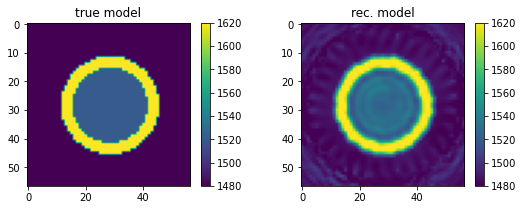

In [20]:
# compare the true vs the FWI recovered model
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.imshow(m, vmin=min_vel, vmax=max_vel)
plt.title('true model')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(model.m_out(), vmin=min_vel, vmax=max_vel)
plt.title('rec. model')
plt.colorbar()
plt.show()

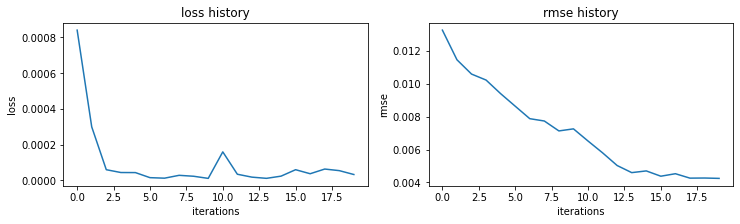

In [21]:
# view the inversion statistics
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(model.loss_history)
plt.title('loss history')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(model.rmse_history)
plt.title('rmse history')
plt.xlabel('iterations')
plt.ylabel('rmse')
plt.show()